In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-10-23 18:16.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]
    inputAdata.obs['cell_id'] = inputAdata.obs.index.tolist()

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [4]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [5]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%sNoDyn/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
resampled_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampled/0_Acute-Chronic_scVelo_postPT.h5ad'
adata = scv.read(resampled_h5ad)

act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act = scv.read(act_h5ad)

act_arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_arm = scv.read(act_arm_h5ad)

act_cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_act_cl13 = scv.read(act_cl13_h5ad)

arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_ARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_arm = scv.read(arm_h5ad)

cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_CL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_cl13 = scv.read(cl13_h5ad)

adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_act_cl13, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_arm, order_df, louvain_new_ordered, louvain_old_ordered)
adata_louvain_name_convert(adata_cl13, order_df, louvain_new_ordered, louvain_old_ordered)

adata_act.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act.obs.index.tolist()]
adata_act_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_arm.obs.index.tolist()]
adata_act_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_cl13.obs.index.tolist()]
adata_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_arm.obs.index.tolist()]
adata_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_cl13.obs.index.tolist()]

In [7]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

In [8]:
### Intersect chromatin regulators & TF & cell surface receptors
surface_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/SurfaceMarkerSelect/master/MM_MARKERS.csv')
surface_genes = surface_df['gene_name'].tolist()
crf_df = pd.read_csv('https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv?token=AGIX2OZNRQF2KWG2ZLZ6ZDC7S35MU')
crf_genes = crf_df['gene_name'].tolist() + [x for x in crf_df['Alternative'].tolist() if str(x) != 'nan']
tf_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/TFclassDataCollection/master/Ravasi_TF.csv')
tf_genes = tf_df['symbol'].tolist()
all_genes = list(set(surface_genes + crf_genes + tf_genes))

### Gene signature genes
gs_plot_use_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv'
gs_plot_use_df = pd.read_csv(gs_plot_use_file)
gs_use = gs_plot_use_df[gs_plot_use_df['plot_use'].notnull()]['gs_name'].tolist()

gs_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
gs_df = pd.read_csv(gs_file)
gs_df_use = gs_df[[True if x in gs_use else False for x in gs_df['gs_name']]]
genes_use = list(set(gs_df_use['gene_symbol'].tolist()))

genes_use = [i for i in genes_use if i in all_genes]

In [260]:
out_dir = wk_dir + '/trajectory_drivers'
Path(out_dir).mkdir(parents=True, exist_ok=True)

out_dir = wk_dir + '/likelihood_genes_drivers'
Path(out_dir).mkdir(parents=True, exist_ok=True)

## Extract likelihood genes for all activated cells ARM v.s. CL13

In [154]:
# Armstrong
adata_ij_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_ij = scv.read(adata_ij_file)
top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
top_genes = top_genes[top_genes > 0]
top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

arm_top_genes = top_genes.index.tolist()
arm_top_genes_score = top_genes.tolist()

# Cl13
adata_ij_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13only/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_ij = scv.read(adata_ij_file)
top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
top_genes = top_genes[top_genes > 0]
top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

cl13_top_genes = top_genes.index.tolist()
cl13_top_genes_score = top_genes.tolist()

# All
adata_ij_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonly/0_Acute-Chronic_scVelo_postPT.h5ad'
adata_ij = scv.read(adata_ij_file)
top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
top_genes = top_genes[top_genes > 0]
top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

all_top_genes = top_genes.index.tolist()
all_top_genes_score = top_genes.tolist()

#Create output df
out_df = pd.DataFrame()

out_df['All_ranked'] = pd.Series(all_top_genes)
out_df['All_ranked_likelihood'] = pd.Series(all_top_genes_score)
out_df['Arm_ranked'] = pd.Series(arm_top_genes)
out_df['Arm_ranked_likelihood'] = pd.Series(arm_top_genes_score)
out_df['Cl13_ranked'] = pd.Series(cl13_top_genes)
out_df['Cl13_ranked_likelihood'] = pd.Series(cl13_top_genes_score)

arm_uniq = list(set(arm_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
cl13_uniq = list(set(cl13_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
common = list(set(cl13_top_genes) & set(arm_top_genes))

out_df['Arm_unique'] = pd.Series(arm_uniq)
out_df['Cl13_unique'] = pd.Series(cl13_uniq)
out_df['Arm-Cl13_common'] = pd.Series(common)
out_df.to_csv("likelihood_genes/act_Arm-Cl13_likelihood_genes.csv", index=False)

## Extract likelihood genes for pairwise clusters

In [152]:
cluster_vs_cluster_scvelo_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/4_scVelo_out_LouvainCluster'

In [ ]:
cp_use = [ ["P2", "P5"], ["P5","P6"], ["P5","P3"],
           ["P2", "P7"], ["P7","P8"],
           ["P2", "P4"], ["P4","P9"], ["P9","P10"] ]

for cp_ij in cp_use:
    cp_ij_old = [louvain_old_ordered[louvain_new_ordered.index(x)] for x in cp_ij]
    if cp_ij_old[1] < cp_ij_old[0]:
        cp_ij_old = [cp_ij_old[1], cp_ij_old[0]]
        cp_ij = [cp_ij[1], cp_ij[0]]
    
    # Armstrong
    use_type = "ARM"
    adata_ij_file = cluster_vs_cluster_scvelo_dir + "/%s-louvain--%s_%s_scVelo.h5ad"%(use_type,cp_ij_old[0], cp_ij_old[1])
    if os.path.exists(adata_ij_file):
        adata_ij = scv.read(adata_ij_file)
        top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
        top_genes = top_genes[top_genes > 0]
        top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

        arm_top_genes = top_genes.index.tolist()
        arm_top_genes_score = top_genes.tolist()
    else:
        arm_top_genes = []
        arm_top_genes_score = []
    
    # Cl13
    use_type = "CL13"
    adata_ij_file = cluster_vs_cluster_scvelo_dir + "/%s-louvain--%s_%s_scVelo.h5ad"%(use_type,cp_ij_old[0], cp_ij_old[1])
    if os.path.exists(adata_ij_file):
        adata_ij = scv.read(adata_ij_file)
        top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
        top_genes = top_genes[top_genes > 0]
        top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

        cl13_top_genes = top_genes.index.tolist()
        cl13_top_genes_score = top_genes.tolist()
    else:
        cl13_top_genes = []
        cl13_top_genes_score = []
    
    # All
    adata_ij_file = cluster_vs_cluster_scvelo_dir + "/louvain--%s_%s_scVelo.h5ad"%(cp_ij_old[0], cp_ij_old[1])
    adata_ij = scv.read(adata_ij_file)
    top_genes = adata_ij.var['fit_likelihood'].sort_values(ascending=False)
    top_genes = top_genes[top_genes > 0]
    top_genes = top_genes[[True if x in genes_use else False for x in top_genes.index]]

    all_top_genes = top_genes.index.tolist()
    all_top_genes_score = top_genes.tolist()
    
    #Create output df
    out_df = pd.DataFrame()

    out_df['All_ranked'] = pd.Series(all_top_genes)
    out_df['All_ranked_likelihood'] = pd.Series(all_top_genes_score)
    out_df['Arm_ranked'] = pd.Series(arm_top_genes)
    out_df['Arm_ranked_likelihood'] = pd.Series(arm_top_genes_score)
    out_df['Cl13_ranked'] = pd.Series(cl13_top_genes)
    out_df['Cl13_ranked_likelihood'] = pd.Series(cl13_top_genes_score)

    arm_uniq = list(set(arm_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
    cl13_uniq = list(set(cl13_top_genes) - (set(cl13_top_genes) & set(arm_top_genes)))
    common = list(set(cl13_top_genes) & set(arm_top_genes))

    out_df['Arm_unique'] = pd.Series(arm_uniq)
    out_df['Cl13_unique'] = pd.Series(cl13_uniq)
    out_df['Arm-Cl13_common'] = pd.Series(common)
    out_df.to_csv("likelihood_genes/%s-%s_Arm-Cl13_likelihood_genes.csv"%(cp_ij[0], cp_ij[1]), index=False)

-----
# Extract & plot driver genes for each trajectory / diverging point

In [13]:
def avg_v_e(driver_genes, adata_use):
    velocity_df = pd.DataFrame(adata_use.layers['velocity'])
    velocity_df.index = adata_use.obs.index
    velocity_df.columns = adata_use.var.index

    expr_df = pd.DataFrame.sparse.from_spmatrix(adata_use.X).sparse.to_dense()
    expr_df.index = adata_use.obs.index
    expr_df.columns = adata_use.var.index
    
    v_avg_df = pd.DataFrame(index=louvain_new_ordered)
    e_avg_df = pd.DataFrame(index=louvain_new_ordered)
    for gene_i in driver_genes:
        gene_i_act_v_df = pd.DataFrame(velocity_df[gene_i])
        gene_i_act_v_df['louvain'] = adata_act.obs['louvain']
        gene_i_act_v_avg = gene_i_act_v_df.groupby('louvain').mean()
        gene_i_act_v_avg.columns = [gene_i]

        gene_i_act_e_df = pd.DataFrame(expr_df[gene_i])
        gene_i_act_e_df['louvain'] = adata_act.obs['louvain']
        gene_i_act_e_avg = gene_i_act_e_df.groupby('louvain').mean()
        gene_i_act_e_avg.columns = [gene_i]

        v_avg_df = v_avg_df.join(gene_i_act_v_avg)
        e_avg_df = e_avg_df.join(gene_i_act_e_avg)
    e_z_df = e_avg_df.copy()
    for col in e_z_df.columns:
        e_z_df[col] = (e_z_df[col] - e_z_df[col].mean())/e_z_df[col].std(ddof=0)
        
    return(v_avg_df, e_avg_df, e_z_df)

## P2 signature & driver gene

In [262]:
###----- Find driver gene files & identify files with P2 in comparison
driver_gene_dir = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes'
dg_files = glob.glob("%s/*.csv"%driver_gene_dir)

p2_dg_files = [x  for x in dg_files if "P2" in x]

all_drivers_file = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes/act_Arm-Cl13_likelihood_genes.csv'
all_drivers_df = pd.read_csv(all_drivers_file)
all_drivers  = all_drivers_df[all_drivers_df['All_ranked_likelihood'] > 0.25]['All_ranked'].tolist()

# Get all the genes that are driver genes in All & in all P2 comparisons
for i in p2_dg_files:
    i_drivers_df = pd.read_csv(i)
    i_drivers  = i_drivers_df[i_drivers_df['All_ranked_likelihood'] > 0.25]['All_ranked'].tolist()
    all_drivers = list(set(all_drivers) & set(i_drivers))

    
###----- Read signature gene spreadsheet & intersect signature and driver genes
sig_genes_file = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/louvain_signature_genes_neworder.csv'
sig_genes_df = pd.read_csv(sig_genes_file)

# Intersect the genes that are expressed higher in P2 & driver genes
p2_sig_genes = sig_genes_df['P2'].tolist()
p2_sig_driver_genes = list(set(p2_sig_genes) & set(all_drivers))


###----- Likelihood
p2_sig_driver_genes_likelihood = all_drivers_df[['All_ranked', 'All_ranked_likelihood']].set_index('All_ranked').loc[p2_sig_driver_genes]
p2_sig_driver_genes_likelihood.to_csv("trajectory_drivers/p2_sig_driver_genes.csv")

In [263]:
use_genes = p2_sig_driver_genes 
use_v_avg_df, use_e_avg_df, use_e_z_df = avg_v_e(use_genes, adata_act)

<AxesSubplot:>

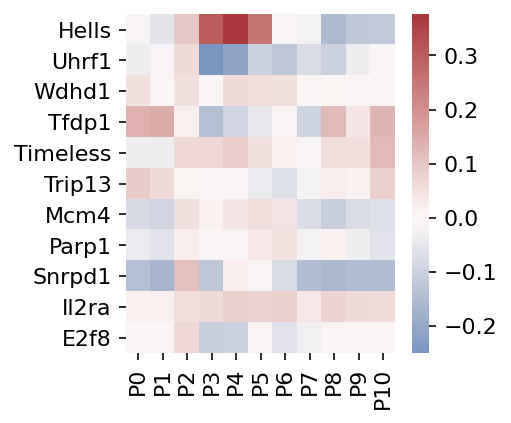

In [264]:
### Plot
rcParams['figure.figsize'] = 3,3
sns.heatmap(use_v_avg_df.T, cmap='vlag', center=0)

#corr_plot.figure.savefig(save_name + ".png")

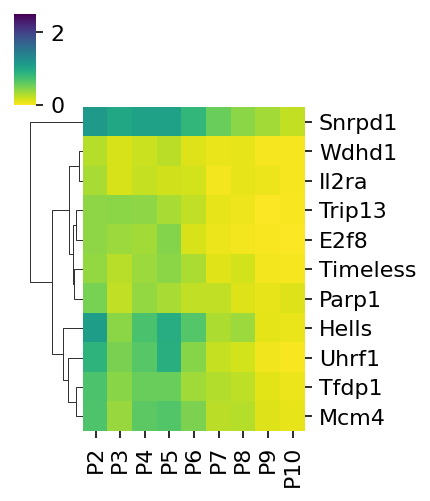

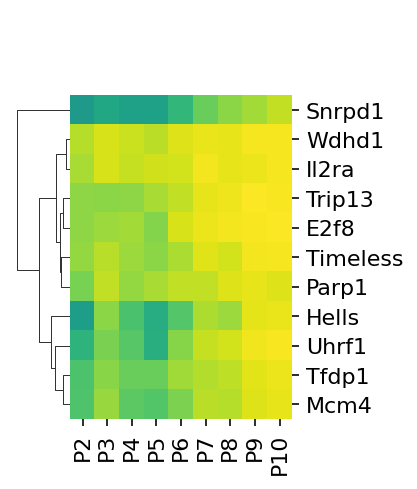

In [265]:
save_name = "trajectory_drivers/p2_sig_driver_genes_expr"

### Plot
rcParams['figure.figsize'] = 3,3

clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,3.5), vmin=0, vmax=2.5)

clustermap.savefig(save_name + ".png")

### Plot
clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,3.5), cbar_pos=None, vmin=0, vmax=2.5)

clustermap.savefig(save_name + "_nolegend.png")

<AxesSubplot:>

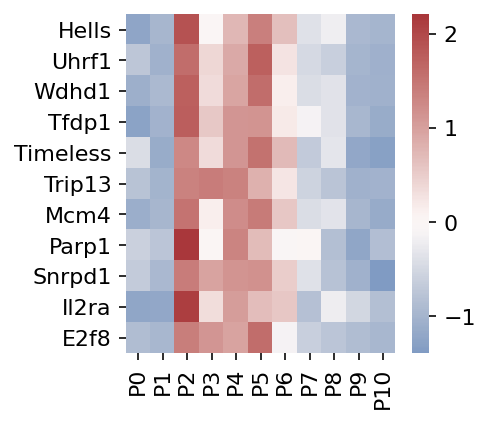

In [266]:
rcParams['figure.figsize'] = 3,3
sns.heatmap(use_e_z_df.T, cmap='vlag', center=0)

## Trajectory specific, Arm / Cl13 -- common / specific drivers

In [267]:
cp = ["P2", "P5"]
cp_old = [louvain_old_ordered[louvain_new_ordered.index(x)] for x in cp]

###----- Find driver gene files & identify files with P2 in comparison
driver_gene_dir = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes'
dg_files = glob.glob("%s/*.csv"%driver_gene_dir)

use_dg_file = [x  for x in dg_files if (cp[0] in x) & (cp[1] in x)][0]
use_dg_df = pd.read_csv(use_dg_file)

all_df = use_dg_df[['All_ranked', 'All_ranked_likelihood']]
all_sig = all_df[all_df['All_ranked_likelihood'] > 0.25]['All_ranked'].tolist()

arm_df = use_dg_df[['Arm_ranked', 'Arm_ranked_likelihood']]
arm_sig = arm_df[arm_df['Arm_ranked_likelihood'] > 0.25]['Arm_ranked'].tolist()

cl13_df = use_dg_df[['Cl13_ranked', 'Cl13_ranked_likelihood']]
cl13_sig = cl13_df[cl13_df['Cl13_ranked_likelihood'] > 0.25]['Cl13_ranked'].tolist()

common_drivers = set(arm_sig) & set(cl13_sig)
arm_drivers = set(arm_sig) # - set(cl13_df[cl13_df['Cl13_ranked_likelihood'] > 0]['Cl13_ranked'].tolist())
cl13_drivers = set(cl13_sig) # - set(arm_df[arm_df['Arm_ranked_likelihood'] > 0]['Arm_ranked'].tolist())

In [268]:
arm_de_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_ARM-NAV/2_DE/Cluster_vs_Cluster'
arm_de_file = arm_de_dir + "/%s/%s_vs_%s_differential.csv"%(cp_old[0], cp_old[0], cp_old[1])
arm_de_df = pd.read_csv(arm_de_file)

cl13_de_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_CL13-NAV/2_DE/Cluster_vs_Cluster'
cl13_de_file = cl13_de_dir + "/%s/%s_vs_%s_differential.csv"%(cp_old[0], cp_old[0], cp_old[1])
cl13_de_df = pd.read_csv(cl13_de_file)

arm_sig_df = arm_de_df[arm_de_df['t-test_logfc'] < 0]
arm_sig_df = arm_sig_df[arm_sig_df['t-test_padj'] <= 0.05]

cl13_sig_df = cl13_de_df[cl13_de_df['t-test_logfc'] < 0]
cl13_sig_df = cl13_sig_df[cl13_sig_df['t-test_padj'] <= 0.05]

arm_drivers_sig = list(set(arm_sig_df['gene_names']) & arm_drivers)
cl13_drivers_sig = list(set(cl13_sig_df['gene_names']) & cl13_drivers)

arm_drivers_sig_df = arm_df[[True if x in arm_drivers_sig else  False for x in arm_df['Arm_ranked']]].reset_index(drop=True)
cl13_drivers_sig_df = cl13_df[[True if x in cl13_drivers_sig else  False for x in cl13_df['Cl13_ranked']]].reset_index(drop=True)

driver_df = pd.DataFrame()
driver_df['Arm_ranked'] = arm_drivers_sig_df['Arm_ranked']
driver_df['Arm_ranked_likelihood'] = arm_drivers_sig_df['Arm_ranked_likelihood']
driver_df['Cl13_ranked'] = cl13_drivers_sig_df['Cl13_ranked']
driver_df['Cl13_ranked_likelihood'] = cl13_drivers_sig_df['Cl13_ranked_likelihood']
driver_df.to_csv("trajectory_drivers/P2-P5_drivers.csv", index=False)

print(len(driver_df))

21


In [269]:
use_genes = arm_drivers_sig
use_adata = adata_act_arm
use_v_avg_df, use_e_avg_df, use_e_z_df = avg_v_e(use_genes, use_adata)

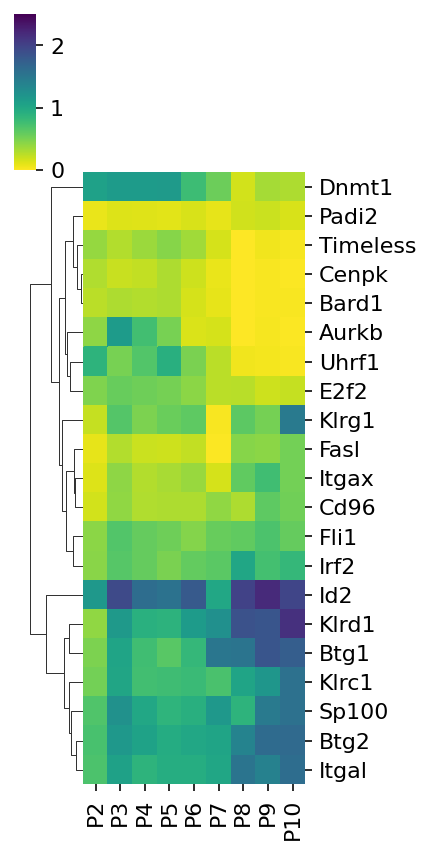

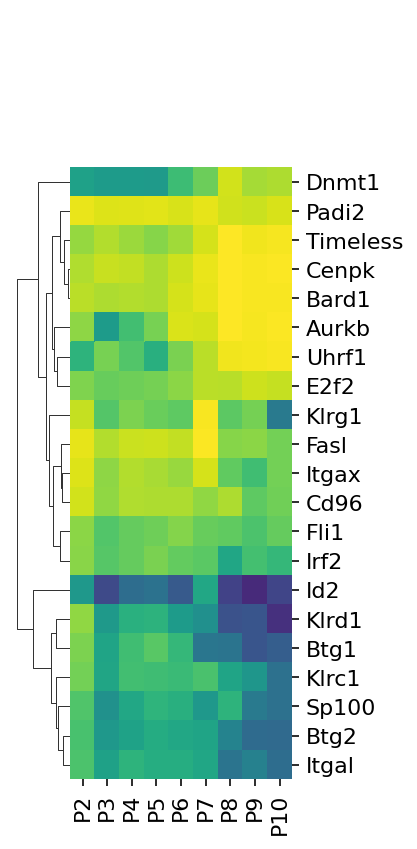

In [270]:
save_name = "trajectory_drivers/p2-p5_sig_driver_genes_expr"

### Plot
rcParams['figure.figsize'] = 3,3

clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,6), vmin=0, vmax=2.5)

clustermap.savefig(save_name + ".png")

### Plot
clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,6), cbar_pos=None, vmin=0, vmax=2.5)

clustermap.savefig(save_name + "_nolegend.png")

*P2 v.s. P7*

In [271]:
cp = ["P2", "P7"]
cp_old = [louvain_old_ordered[louvain_new_ordered.index(x)] for x in cp]

###----- Find driver gene files & identify files with P2 in comparison
driver_gene_dir = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes'
dg_files = glob.glob("%s/*.csv"%driver_gene_dir)

use_dg_file = [x  for x in dg_files if (cp[0] in x) & (cp[1] in x)][0]
use_dg_df = pd.read_csv(use_dg_file)

all_df = use_dg_df[['All_ranked', 'All_ranked_likelihood']]
all_sig = all_df[all_df['All_ranked_likelihood'] > 0.25]['All_ranked'].tolist()

arm_df = use_dg_df[['Arm_ranked', 'Arm_ranked_likelihood']]
arm_sig = arm_df[arm_df['Arm_ranked_likelihood'] > 0.25]['Arm_ranked'].tolist()

cl13_df = use_dg_df[['Cl13_ranked', 'Cl13_ranked_likelihood']]
cl13_sig = cl13_df[cl13_df['Cl13_ranked_likelihood'] > 0.25]['Cl13_ranked'].tolist()

common_drivers = set(arm_sig) & set(cl13_sig)
arm_drivers = set(arm_sig) # - set(cl13_sig)
cl13_drivers = set(cl13_sig) # - set(arm_sig)

In [272]:
arm_de_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_ARM-NAV/2_DE/Cluster_vs_Cluster'
arm_de_file = arm_de_dir + "/%s/%s_vs_%s_differential.csv"%(cp_old[0], cp_old[0], cp_old[1])
arm_de_df = pd.read_csv(arm_de_file)

cl13_de_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_CL13-NAV/2_DE/Cluster_vs_Cluster'
cl13_de_file = cl13_de_dir + "/%s/%s_vs_%s_differential.csv"%(cp_old[0], cp_old[0], cp_old[1])
cl13_de_df = pd.read_csv(cl13_de_file)

arm_sig_df = arm_de_df[arm_de_df['t-test_logfc'] < 0]
arm_sig_df = arm_sig_df[arm_sig_df['t-test_padj'] <= 0.05]

cl13_sig_df = cl13_de_df[cl13_de_df['t-test_logfc'] < 0]
cl13_sig_df = cl13_sig_df[cl13_sig_df['t-test_padj'] <= 0.05]

arm_drivers_sig = list( set(arm_sig_df['gene_names']) & arm_drivers)
cl13_drivers_sig = list(set(cl13_sig_df['gene_names']) & cl13_drivers)

arm_drivers_sig_df = arm_df[[True if x in arm_drivers_sig else  False for x in arm_df['Arm_ranked']]].reset_index(drop=True)
cl13_drivers_sig_df = cl13_df[[True if x in cl13_drivers_sig else  False for x in cl13_df['Cl13_ranked']]].reset_index(drop=True)

driver_df = pd.DataFrame()
driver_df['Arm_ranked'] = arm_drivers_sig_df['Arm_ranked']
driver_df['Arm_ranked_likelihood'] = arm_drivers_sig_df['Arm_ranked_likelihood']
driver_df['Cl13_ranked'] = cl13_drivers_sig_df['Cl13_ranked']
driver_df['Cl13_ranked_likelihood'] = cl13_drivers_sig_df['Cl13_ranked_likelihood']
driver_df.to_csv("trajectory_drivers/P2-P7_drivers.csv", index=False)

print(len(driver_df))

49


In [273]:
use_genes = arm_drivers_sig
use_adata = adata_act_arm
use_v_avg_df, use_e_avg_df, use_e_z_df = avg_v_e(use_genes, use_adata)

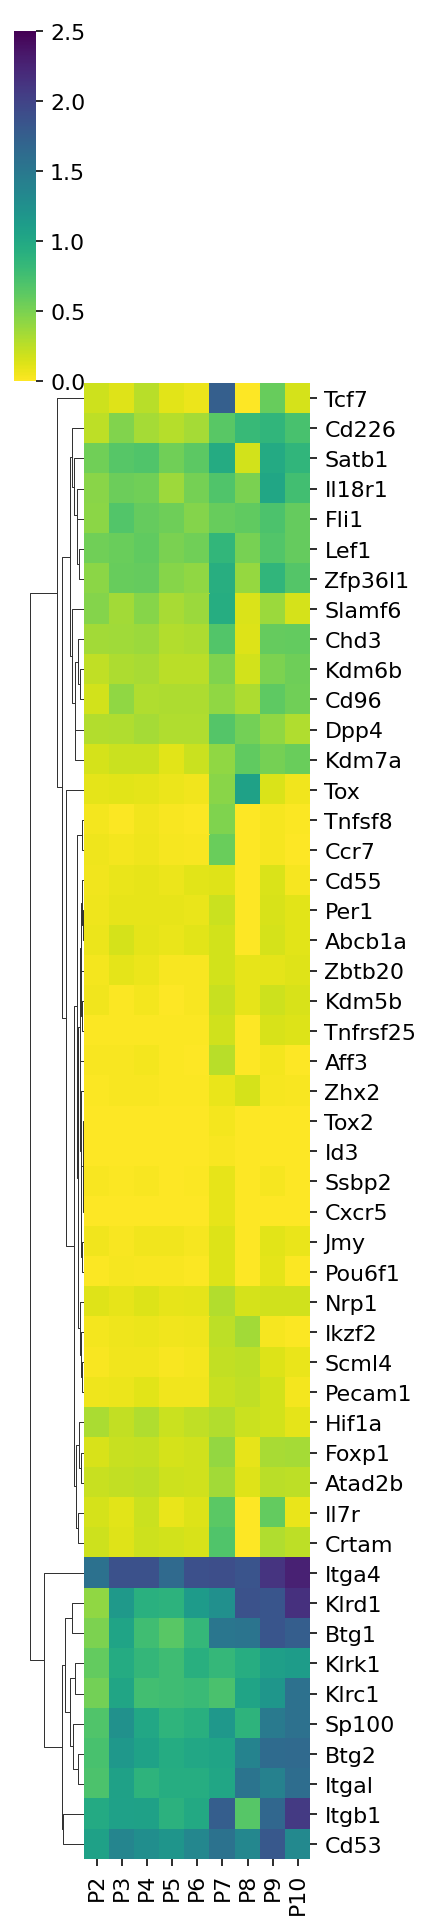

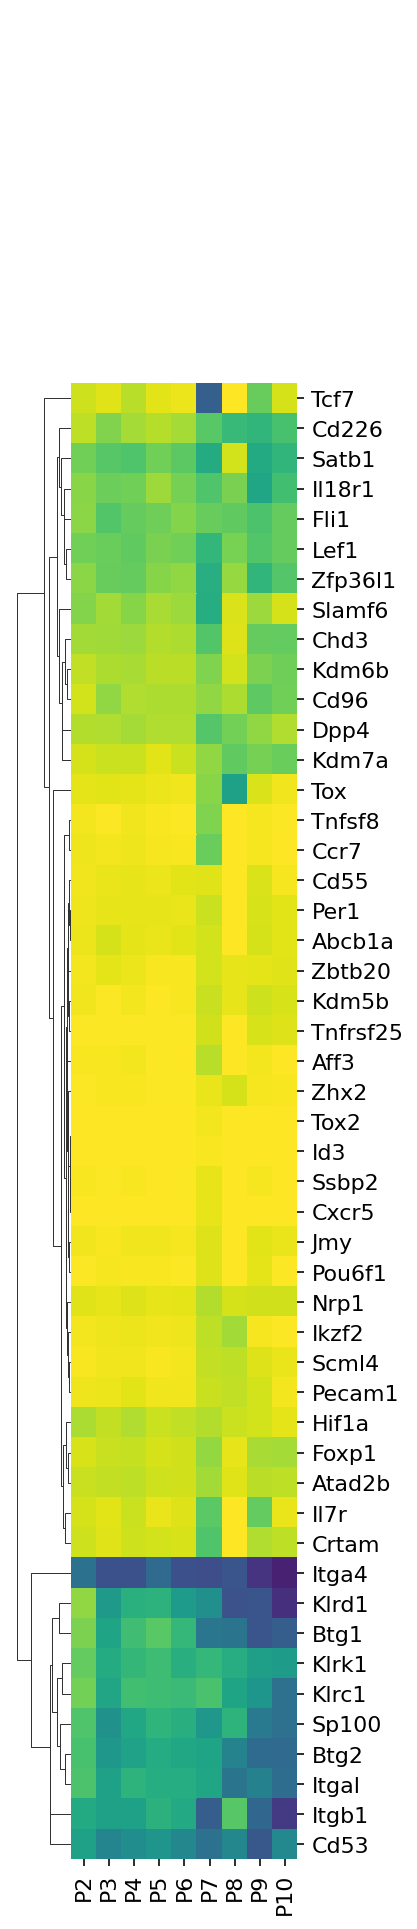

In [274]:
save_name = "trajectory_drivers/p2-p7_sig_driver_genes_expr"

### Plot
rcParams['figure.figsize'] = 3,3

clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,13.5), vmin=0, vmax=2.5)

clustermap.savefig(save_name + ".png")

### Plot
clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,13.5), cbar_pos=None, vmin=0, vmax=2.5)

clustermap.savefig(save_name + "_nolegend.png")

*P2 v.s. P4*

In [275]:
cp = ["P2", "P4"]
cp_old = [louvain_old_ordered[louvain_new_ordered.index(x)] for x in cp]

###----- Find driver gene files & identify files with P2 in comparison
driver_gene_dir = base_dir + '/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes'
dg_files = glob.glob("%s/*.csv"%driver_gene_dir)

use_dg_file = [x  for x in dg_files if (cp[0] in x) & (cp[1] in x)][0]
use_dg_df = pd.read_csv(use_dg_file)

all_df = use_dg_df[['All_ranked', 'All_ranked_likelihood']]
all_sig = all_df[all_df['All_ranked_likelihood'] > 0.25]['All_ranked'].tolist()

arm_df = use_dg_df[['Arm_ranked', 'Arm_ranked_likelihood']]
arm_sig = arm_df[arm_df['Arm_ranked_likelihood'] > 0.25]['Arm_ranked'].tolist()

cl13_df = use_dg_df[['Cl13_ranked', 'Cl13_ranked_likelihood']]
cl13_sig = cl13_df[cl13_df['Cl13_ranked_likelihood'] > 0.25]['Cl13_ranked'].tolist()

common_drivers = set(arm_sig) & set(cl13_sig)
arm_drivers = set(arm_sig) # - set(cl13_sig)
cl13_drivers = set(cl13_sig) #- set(arm_sig)

In [276]:
arm_de_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_ARM-NAV/2_DE/Cluster_vs_Cluster'
arm_de_file = arm_de_dir + "/%s/%s_vs_%s_differential.csv"%(cp_old[0], cp_old[0], cp_old[1])
arm_de_df = pd.read_csv(arm_de_file)

cl13_de_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/1_Scanpy_out_resampled_CL13-NAV/2_DE/Cluster_vs_Cluster'
cl13_de_file = cl13_de_dir + "/%s/%s_vs_%s_differential.csv"%(cp_old[0], cp_old[0], cp_old[1])
cl13_de_df = pd.read_csv(cl13_de_file)

arm_sig_df = arm_de_df[arm_de_df['t-test_logfc'] < 0]
arm_sig_df = arm_sig_df[arm_sig_df['t-test_padj'] <= 0.05]

cl13_sig_df = cl13_de_df[cl13_de_df['t-test_logfc'] < 0]
cl13_sig_df = cl13_sig_df[cl13_sig_df['t-test_padj'] <= 0.05]

arm_drivers_sig = list( set(arm_sig_df['gene_names']) & arm_drivers)
cl13_drivers_sig = list(set(cl13_sig_df['gene_names']) & cl13_drivers)

arm_drivers_sig_df = arm_df[[True if x in arm_drivers_sig else  False for x in arm_df['Arm_ranked']]].reset_index(drop=True)
cl13_drivers_sig_df = cl13_df[[True if x in cl13_drivers_sig else  False for x in cl13_df['Cl13_ranked']]].reset_index(drop=True)

driver_df = pd.DataFrame()
driver_df['Arm_ranked'] = arm_drivers_sig_df['Arm_ranked']
driver_df['Arm_ranked_likelihood'] = arm_drivers_sig_df['Arm_ranked_likelihood']
driver_df['Cl13_ranked'] = cl13_drivers_sig_df['Cl13_ranked']
driver_df['Cl13_ranked_likelihood'] = cl13_drivers_sig_df['Cl13_ranked_likelihood']
driver_df.to_csv("trajectory_drivers/P2-P4_drivers.csv", index=False)

print(len(driver_df))

29


In [277]:
use_genes = arm_drivers_sig
use_adata = adata_act_arm
use_v_avg_df, use_e_avg_df, use_e_z_df = avg_v_e(use_genes, use_adata)

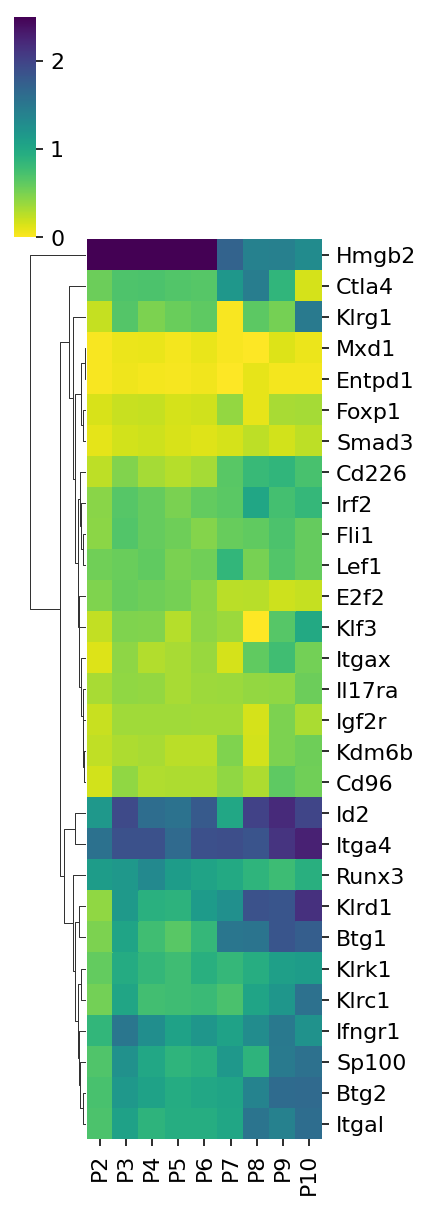

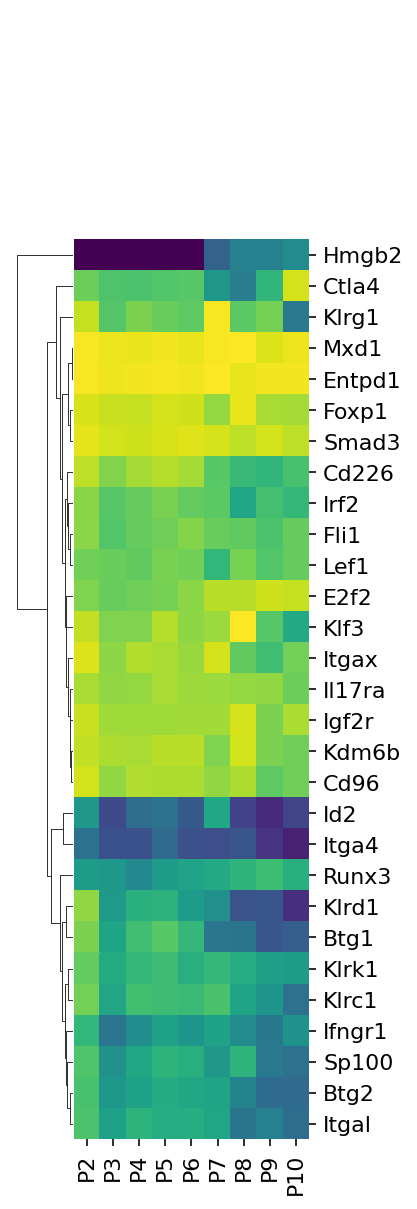

In [278]:
save_name = "trajectory_drivers/p2-p4_sig_driver_genes_expr"

### Plot
rcParams['figure.figsize'] = 3,3

clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,8.5), vmin=0, vmax=2.5)

clustermap.savefig(save_name + ".png")

### Plot
clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
               col_cluster=False, figsize=(3,8.5), cbar_pos=None, vmin=0, vmax=2.5)

clustermap.savefig(save_name + "_nolegend.png")

## Overlapping driver genes in 3 main paths

In [279]:
p2_p4_file = "trajectory_drivers/P2-P4_drivers.csv"
p2_p5_file = "trajectory_drivers/P2-P5_drivers.csv"
p2_p7_file = "trajectory_drivers/P2-P7_drivers.csv"

p4_df = pd.read_csv(p2_p4_file)
p5_df = pd.read_csv(p2_p5_file)
p7_df = pd.read_csv(p2_p7_file)

In [280]:
from matplotlib_venn import venn3, venn3_circles

In [306]:
###----- Arm
for use, use_data in zip(['Arm', 'Cl13'], [adata_act_arm, adata_act_cl13]):

    p4_list = [x for x in p4_df['%s_ranked'%use].tolist() if str(x) != 'nan']
    p5_list = [x for x in p5_df['%s_ranked'%use].tolist() if str(x) != 'nan']
    p7_list = [x for x in p7_df['%s_ranked'%use].tolist() if str(x) != 'nan']
    
    plt.figure(figsize=(4,4))
    venn3([set(p4_list),set(p7_list),set(p5_list)], ("P4", "P7", "P5"))
    plt.savefig("trajectory_drivers/%s_venn3.png"%use)
    plt.close()


    all_overlap = (set(p4_list) & set(p5_list) )& set(p7_list)
    p4_p5_overlap = (set(p4_list) & set(p5_list) ) - all_overlap 
    p4_p7_overlap = (set(p4_list) & set(p7_list) ) - all_overlap 
    p5_p7_overlap = (set(p5_list) & set(p7_list) ) - all_overlap
    p4_sp = set(p4_list) - p4_p5_overlap - p4_p7_overlap - all_overlap
    p5_sp = set(p5_list) - p4_p5_overlap - p5_p7_overlap - all_overlap
    p7_sp = set(p7_list) - p4_p7_overlap - p5_p7_overlap - all_overlap

    plot_dict = {"all_overlap": all_overlap, 
                 "p4_p5_overlap": p4_p5_overlap, "p4_p7_overlap": p4_p7_overlap, "p5_p7_overlap": p5_p7_overlap, 
                "p4_sp": p4_sp, "p5_sp": p5_sp, "p7_sp": p7_sp}

    for key, val in plot_dict.items():
        save_name = "trajectory_drivers/%s_trajectory-from-P2___%s___driver_genes_expr"%(use, key)
        print(save_name)

        ### Plot
        if (len(val) > 0):
            use_v_avg_df, use_e_avg_df, use_e_z_df = avg_v_e(val, use_adata)
            if (len(val) > 2):
                clustermap = sns.clustermap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
                               col_cluster=False, figsize=(3,(0.27*len(val) + 0.5)), cbar_pos=None, vmin=0, vmax=2.5)

                clustermap.savefig(save_name + "_nolegend.png")
                plt.close()
            else:
                rcParams['figure.figsize'] = 3, ( 0.3*len(val) + 0.3 )
                heatmap = sns.heatmap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
                                       vmin=0, vmax=2.5, cbar=False)
                rcParams['figure.figsize'] = 3, ( 0.3*len(val) + 0.3 )
                heatmap = heatmap.get_figure()    
                heatmap.savefig(save_name + "_nolegend.png")
                plt.close()

trajectory_drivers/Arm_trajectory-from-P2___all_overlap___driver_genes_expr
trajectory_drivers/Arm_trajectory-from-P2___p4_p5_overlap___driver_genes_expr
trajectory_drivers/Arm_trajectory-from-P2___p4_p7_overlap___driver_genes_expr
trajectory_drivers/Arm_trajectory-from-P2___p5_p7_overlap___driver_genes_expr
trajectory_drivers/Arm_trajectory-from-P2___p4_sp___driver_genes_expr
trajectory_drivers/Arm_trajectory-from-P2___p5_sp___driver_genes_expr
trajectory_drivers/Arm_trajectory-from-P2___p7_sp___driver_genes_expr
trajectory_drivers/Cl13_trajectory-from-P2___all_overlap___driver_genes_expr
trajectory_drivers/Cl13_trajectory-from-P2___p4_p5_overlap___driver_genes_expr
trajectory_drivers/Cl13_trajectory-from-P2___p4_p7_overlap___driver_genes_expr
trajectory_drivers/Cl13_trajectory-from-P2___p5_p7_overlap___driver_genes_expr
trajectory_drivers/Cl13_trajectory-from-P2___p4_sp___driver_genes_expr
trajectory_drivers/Cl13_trajectory-from-P2___p5_sp___driver_genes_expr
trajectory_drivers/Cl13_

trajectory_drivers/Cl13_trajectory-from-P2___all_overlap___driver_genes_expr


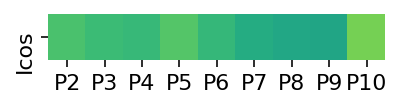

In [315]:
key = 'all_overlap'
val = plot_dict[key]

save_name = "trajectory_drivers/%s_trajectory-from-P2___%s___driver_genes_expr"%(use, key)
print(save_name)

use_v_avg_df, use_e_avg_df, use_e_z_df = avg_v_e(val, use_adata)

rcParams['figure.figsize'] = 3, 0.4
heatmap = sns.heatmap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
                       vmin=0, vmax=2.5, cbar=False)
heatmap = heatmap.get_figure()    
heatmap.savefig(save_name + "_nolegend.png")

trajectory_drivers/Cl13_trajectory-from-P2___p5_p7_overlap___driver_genes_expr


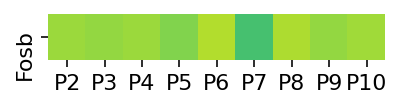

In [316]:
key = 'p5_p7_overlap'
val = plot_dict[key]

save_name = "trajectory_drivers/%s_trajectory-from-P2___%s___driver_genes_expr"%(use, key)
print(save_name)

use_v_avg_df, use_e_avg_df, use_e_z_df = avg_v_e(val, use_adata)

rcParams['figure.figsize'] = 3, 0.4
heatmap = sns.heatmap(use_e_avg_df.loc[louvain_new_ordered[2:]].T, cmap='viridis_r', 
                       vmin=0, vmax=2.5, cbar=False)
heatmap = heatmap.get_figure()    
heatmap.savefig(save_name + "_nolegend.png")